    Efficient Net B7 
    pooling = Global Average Pooling
    Regulation Drop Connefct 0.4 , Drop Out 0.5 L2 Norm 0.01
    Optimizer = LA Nadam
    Classifiter = Softmax
    Loss  Categorical Cross Entropy
    B,E = 8, 60
    Learning rate 0.0001

###### module

In [1]:
# basic module
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
import glob
import time
import pickle

plt.style.use('seaborn-dark')
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = False


# image module
import cv2
from pydicom import dcmread
import pylibjpeg
from PIL import Image
import pydicom as dcm
from pydicom import dcmread
from pydicom.data import get_testdata_file



# dataset
df = pd.read_csv('dataset.csv',index_col=0)

### Declare

In [32]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b7'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes = 7)


600
Loaded pretrained weights for efficientnet-b7


### Data Load

In [33]:
batch_size = 1
random_seed = 10
random.seed(random_seed)
torch.manual_seed(random_seed)

### Dataset

In [34]:
from torchvision import transforms, datasets
data_path = '/home/ncp/workspace/data/crop'
crop_dataset = datasets.ImageFolder(data_path,
                                   transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ]))
crop_dataset

Dataset ImageFolder
    Number of datapoints: 3999
    Root location: /home/ncp/workspace/data/crop
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [35]:
crop_dataset.classes

['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6']

### Data split

In [36]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(crop_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(crop_dataset, train_idx)
tmp_dataset       = Subset(crop_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

### Declare Data Loader

In [37]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 1,  tvt : 3199 / 400 / 400


### Data check

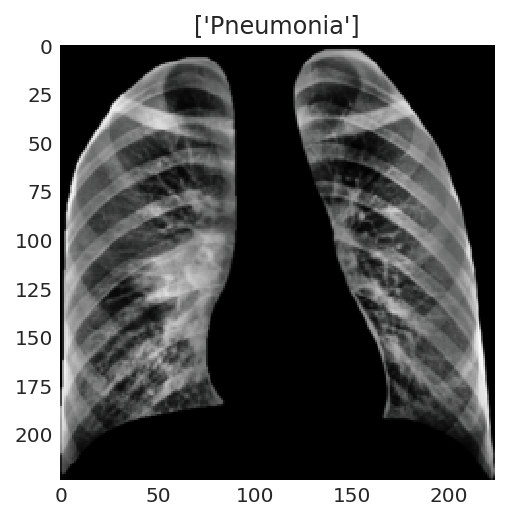

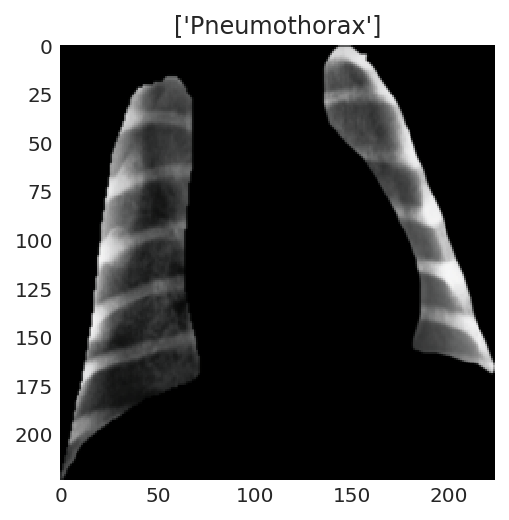

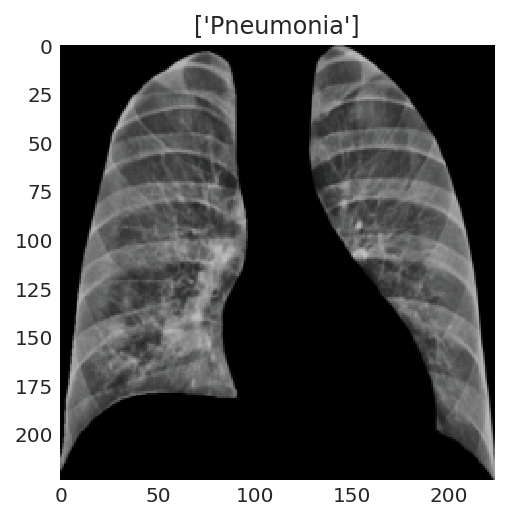

In [38]:
import torchvision
def imshow(inp, title=None):
    inp = inp.numpy().transpose( (1,2,0) )
    mean = np.array( [0.485, 0.456, 0.406] )
    std = np.array( [0.229, 0.224, 0.225] )
    inp = std * inp + mean
    inp = np.clip(inp, 0 , 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
num_show_img = 7

class_names = {
    "0" : 'Normal',
    "1" : 'Pneumothorax',
    "2" : 'COP',
    "3" : 'Atelectasis',
    "4" : 'RDS',
    "5" : 'Pneumonia',
    "6" : 'effusion'
}

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img]) 
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

### Train code

In [39]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'Lung_disease.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

### Setting

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [41]:
# # device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")  # set gpu

# model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

### Train

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu") 

model = model.to(device)
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.72 GiB total capacity; 30.00 MiB already allocated; 4.75 MiB free; 30.00 MiB reserved in total by PyTorch)